# Image Generation with VAEs and GANs on the Quick, Draw! Dataset

This project delves into the field of generative deep learning, focusing on two prominent model architectures: Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs). The capabilities of these models are explored in generating novel images, using the unique and diverse Quick, Draw! dataset as a training ground.

## Overview

Two powerful generative models are implemented and compared:

*   **Variational Autoencoders (VAEs):** VAEs represent a probabilistic approach to autoencoders. They learn a compressed, latent representation of input data by mapping it to a probability distribution (typically a Gaussian). Sampling from this learned latent space and passing the samples through a decoder network enables VAEs to generate new, synthetic data points.
*   **Generative Adversarial Networks (GANs):** GANs employ an adversarial training process, where a generator network learns to create realistic data samples from random noise, and a discriminator network learns to distinguish between real data and the generator's creations. This competitive process drives both networks to improve, ultimately leading to a generator capable of producing highly realistic outputs.

## Dataset

The project utilizes the **Quick, Draw! dataset**, a collection of 50 million simple drawings created by players of the online game "Quick, Draw!". This dataset encompasses 345 different categories, providing a wide range of visual concepts. This project specifically focuses on:

*   **Image Format:** 28x28 grayscale images.
*   **Selected Classes:** Five distinct classes are chosen for image generation: cat, dog, bird, tree, and house.
*   **Sample Size:** 20,000 images per class are used for training (with experimentation using sample sizes from 15,000 to 500,000).

## Model Architecture and Training

Both the VAE and GAN models are implemented using the PyTorch deep learning framework. The training process is accelerated by leveraging the power of GPU computation through either Apple's Metal Performance Shaders (MPS) framework on Apple silicon (for the GAN) or CUDA on an NVIDIA T4 GPU on Google Colab (for the VAE).

The models share the following key hyperparameters:

*   **Latent Dimension:** 128 (with experimentation using 32, 64, and 256 to explore the impact of latent space dimensionality).
*   **Batch Size:** 64 (with experimentation using 32, 64, 128, 256, 512, and 1024 to optimize training efficiency).
*   **Training Epochs:** 50. Early stopping is implemented to prevent overfitting and optimize training time.

The core objective of the training process is to enable the models to:

1. **Encode:** Map input drawings from the Quick, Draw! dataset into a compressed latent space representation that captures the essential features of each class.
2. **Generate:** Produce new, plausible drawings by sampling from the learned latent space (for VAEs) or from random noise (for GANs).
3. **Synthesize:** Generate realistic synthetic drawings that exhibit the characteristic features and diversity of the training data.

# Environment Setup

This project is compatible with Python 3.9. The necessary packages can be installed using pip.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Constants ---
IMAGE_SIZE = 28       # Height and width of the images
CHANNELS = 1          # Number of channels in the images (grayscale)
BATCH_SIZE = 64       # Batch size for training
LATENT_DIM_GAN = 128  # Dimension of the random noise vector for the generator
EPOCHS = 50           # Number of training epochs (you might need more)
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']  # Chosen classes
DATA_DIR = "quickdraw_data"  # Directory to store the data
MAX_ITEMS_PER_CLASS = 5000 # Limit the number of samples per class - this number is changed between different expriments

# --- Check for CUDA (GPU support) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**Setting Random Seeds for Reproducibility**: 

42 is a common choice (it's the "Answer to the Ultimate Question of Life, the Universe, and Everything" from The Hitchhiker's Guide to the Galaxy). The important thing is to use the same seed consistently to get the same results.

In [ ]:
# --- Set random seed for reproducibility ---
torch.manual_seed(42)
np.random.seed(42)

# Data Download and Preparation

- **Class Selection**: Choose your five classes: cat, dog, bird, tree, house.

- **Download**: Use the provided download_quickdraw_data function (from the "Data Loading and Preparation" section) to download the .npy files for the chosen classes. This function efficiently checks if the files already exist locally.

- **Load Data**: Use the load_quickdraw_data function to load the data into memory.

In [19]:
# --- Data Loading and Preparation ---
import os
import urllib.request
from tqdm import tqdm

def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    """Downloads Quick, Draw! data if not already present."""
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    """Loads Quick, Draw! data into memory."""
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            print("Please ensure the data has been downloaded correctly.")
            return None, None

    return np.concatenate(all_data), np.concatenate(all_labels)

# Download and load data
download_quickdraw_data(CLASSES)
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)

# Reshape and normalize data
x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.

# Split into training and testing sets
num_samples = len(x_data)
train_size = int(0.8 * num_samples)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train).long()  # Use long for class labels
y_test = torch.from_numpy(y_test).long()

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
x_train shape: torch.Size([400000, 1, 28, 28])
y_train shape: torch.Size([400000])
x_test shape: torch.Size([100000, 1, 28, 28])
y_test shape: torch.Size([100000])


# VAE Building & Training

> This training process, the NVDIA GPU T4 was used on Google Colab to froster 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import urllib.request
from tqdm import tqdm

# --- Constants ---
IMAGE_SIZE = 28
CHANNELS = 1
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']
DATA_DIR = "quickdraw_data"
MAX_ITEMS_PER_CLASS = 100000

# --- Ensure Reproducibility ---
torch.manual_seed(42)
np.random.seed(42)

In [5]:
# --- Configuration Class ---
class Config:
    def __init__(self, batch_size=512, latent_dim=128, epochs=50, learning_rate=0.0005, weight_decay=1e-5,
                 beta_start=0.1, beta_end=1.0, beta_increase_epochs=25, early_stopping_patience=10,
                 lr_scheduler_patience=5, lr_scheduler_factor=0.5,
                 device=None):
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_increase_epochs = beta_increase_epochs
        self.early_stopping_patience = early_stopping_patience
        self.lr_scheduler_patience = lr_scheduler_patience
        self.lr_scheduler_factor = lr_scheduler_factor

        # Device Configuration
        if device is None:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
            elif torch.backends.mps.is_available():
                self.device = torch.device("mps")
            else:
                self.device = torch.device("cpu")
        else:
            self.device = device

        print(f"Using device: {self.device}")

In [6]:
# --- Data Loader Class ---
class QuickDrawDataLoader:
    def __init__(self, config, data_dir=DATA_DIR, classes=CLASSES, max_items_per_class=MAX_ITEMS_PER_CLASS):
        self.config = config
        self.data_dir = data_dir
        self.classes = classes
        self.max_items_per_class = max_items_per_class
        self.base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

    def download(self):
        os.makedirs(self.data_dir, exist_ok=True)
        for class_name in self.classes:
            file_name = f"{class_name.replace(' ', '_')}.npy"
            file_path = os.path.join(self.data_dir, file_name)
            if not os.path.exists(file_path):
                print(f"Downloading {file_name}...")
                with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                    urllib.request.urlretrieve(self.base_url + file_name, file_path,
                                               reporthook=lambda b, bsize, tsize: t.update(bsize))
            else:
                print(f"{file_name} already downloaded.")

    def load_data(self):
        all_data = []
        all_labels = []
        for idx, class_name in enumerate(self.classes):
            file_name = f"{class_name.replace(' ', '_')}.npy"
            file_path = os.path.join(self.data_dir, file_name)
            try:
                data = np.load(file_path)
                if data.shape[0] > self.max_items_per_class:
                    data = data[:self.max_items_per_class]
                all_data.append(data)
                all_labels.append(np.full((data.shape[0],), idx))
            except FileNotFoundError:
                print(f"Error: File not found: {file_path}")
                return None, None

        return np.concatenate(all_data), np.concatenate(all_labels)

    def get_data_loaders(self):
        self.download()
        x_data, labels = self.load_data()

        if x_data is None or labels is None:
            print("Data loading failed. Please check previous steps.")
            return None, None

        x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.

        num_samples = len(x_data)
        train_size = int(0.8 * num_samples)
        x_train, x_test = x_data[:train_size], x_data[train_size:]
        y_train, y_test = labels[:train_size], labels[train_size:]

        x_train = torch.from_numpy(x_train).float()
        x_test = torch.from_numpy(x_test).float()
        y_train = torch.from_numpy(y_train).long()
        y_test = torch.from_numpy(y_test).long()

        train_dataset = TensorDataset(x_train, y_train)
        test_dataset = TensorDataset(x_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True, num_workers=2,
                                  pin_memory=(str(self.config.device) == "cuda"))
        test_loader = DataLoader(test_dataset, batch_size=self.config.batch_size, shuffle=False, num_workers=2,
                                 pin_memory=(str(self.config.device) == "cuda"))

        return train_loader, test_loader

In [7]:
# --- VAE Model Components ---
class Encoder(nn.Module):
    def __init__(self, config, channels=CHANNELS):
        super(Encoder, self).__init__()
        self.config = config
        self.conv1 = nn.Conv2d(channels, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.flatten = nn.Flatten()
        self.conv_output_size = 128 * 7 * 7 # For 28x28 images
        self.fc_mu = nn.Linear(self.conv_output_size, self.config.latent_dim)
        self.fc_var = nn.Linear(self.conv_output_size, self.config.latent_dim)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        return self.fc_mu(x), self.fc_var(x)

class Decoder(nn.Module):
    def __init__(self, config, channels=CHANNELS):
        super(Decoder, self).__init__()
        self.config = config
        self.conv_output_size = 128 * 7 * 7 # For 28x28 images
        self.fc = nn.Linear(self.config.latent_dim, self.conv_output_size)
        self.conv_transpose1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv_transpose2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv_transpose3 = nn.ConvTranspose2d(32, channels, 3, stride=1, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 7, 7)
        x = F.leaky_relu(self.bn1(self.conv_transpose1(x)))
        x = F.leaky_relu(self.bn2(self.conv_transpose2(x)))
        x = self.conv_transpose3(x)
        return x

class Sampling(nn.Module):
    def forward(self, args):
        mu, log_var = args
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

In [8]:
# --- VAE Model ---
class VAE(nn.Module):
    def __init__(self, config, channels=CHANNELS):
        super(VAE, self).__init__()
        self.config = config
        self.encoder = Encoder(self.config, channels)
        self.decoder = Decoder(self.config, channels)
        self.sampling = Sampling()

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.sampling((z_mean, z_log_var))
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

In [ ]:
# --- Loss Function ---
def vae_loss(recon_x, x, mu, log_var, beta=1.0):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + beta * KLD

# --- Trainer Class ---
class Trainer:
    def __init__(self, model, config, train_loader, test_loader):
        self.model = model
        self.config = config
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = Adam(self.model.parameters(), lr=self.config.learning_rate, weight_decay=self.config.weight_decay)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=self.config.lr_scheduler_patience,
                                           factor=self.config.lr_scheduler_factor, verbose=True)
        if str(self.config.device) == "cuda":
          self.scaler = torch.amp.GradScaler()
        self.train_losses = []
        self.reconstruction_losses = []
        self.kl_losses = []
        self.best_test_loss = float('inf')
        self.early_stopping_counter = 0

    def train_epoch(self, epoch, beta):
        self.model.train()
        total_loss = 0
        recon_loss = 0
        kl_loss = 0

        for batch_idx, (data, _) in enumerate(self.train_loader):
            data = data.to(self.config.device, non_blocking=True)
            self.optimizer.zero_grad()

            with torch.autocast(device_type=str(self.config.device), enabled=(str(self.config.device) == "cuda")):
                recon_batch, mu, log_var = self.model(data)
                loss = vae_loss(recon_batch, data, mu, log_var, beta)

            if str(self.config.device) == "cuda":
              self.scaler.scale(loss).backward()
              self.scaler.step(self.optimizer)
              self.scaler.update()
            else:
              loss.backward()
              self.optimizer.step()

            total_loss += loss.item()
            recon_loss += F.binary_cross_entropy_with_logits(recon_batch, data, reduction='sum').item()
            kl_loss += -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()).item()

        avg_loss = total_loss / len(self.train_loader.dataset)
        avg_recon_loss = recon_loss / len(self.train_loader.dataset)
        avg_kl_loss = kl_loss / len(self.train_loader.dataset)

        return avg_loss, avg_recon_loss, avg_kl_loss

    def evaluate(self, beta):
        self.model.eval()
        total_loss = 0
        recon_loss = 0
        kl_loss = 0

        with torch.no_grad():
            for data, _ in self.test_loader:
                data = data.to(self.config.device, non_blocking=True)
                recon_batch, mu, log_var = self.model(data)
                loss = vae_loss(recon_batch, data, mu, log_var, beta)
                total_loss += loss.item()
                recon_loss += F.binary_cross_entropy_with_logits(recon_batch, data, reduction='sum').item()
                kl_loss += -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()).item()

        avg_loss = total_loss / len(self.test_loader.dataset)
        avg_recon_loss = recon_loss / len(self.test_loader.dataset)
        avg_kl_loss = kl_loss / len(self.test_loader.dataset)

        return avg_loss, avg_recon_loss, avg_kl_loss

    def train(self):
        print("Starting training...")
        start_time = time.time()
        for epoch in range(self.config.epochs):
            epoch_start_time = time.time()

            # Beta scheduling
            beta = min(self.config.beta_end,
                       self.config.beta_start + (self.config.beta_end - self.config.beta_start) * epoch / self.config.beta_increase_epochs)

            train_loss, train_recon_loss, train_kl_loss = self.train_epoch(epoch, beta)
            test_loss, test_recon_loss, test_kl_loss = self.evaluate(beta)

            self.train_losses.append(train_loss)
            self.reconstruction_losses.append(train_recon_loss)
            self.kl_losses.append(train_kl_loss)

            print(f"====> Epoch: {epoch + 1}/{self.config.epochs} Average train loss: {train_loss:.4f}, "
                  f"Reconstruction loss: {train_recon_loss:.4f}, "
                  f"KL loss: {train_kl_loss:.4f}, "
                  f"Beta: {beta:.4f}, "
                  f"Time: {time.time() - epoch_start_time:.2f} seconds")

            print(f"====> Epoch: {epoch + 1}/{self.config.epochs} Average test loss: {test_loss:.4f}, "
                  f"Reconstruction loss: {test_recon_loss:.4f}, "
                  f"KL loss: {test_kl_loss:.4f}")

            self.scheduler.step(test_loss)

            # Early stopping check
            if test_loss < self.best_test_loss:
                self.best_test_loss = test_loss
                self.early_stopping_counter = 0
                torch.save(self.model.state_dict(), "best_vae_model.h5")
            else:
                self.early_stopping_counter += 1

            if self.early_stopping_counter >= self.config.early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        print(f"Total training time: {time.time() - start_time:.2f} seconds")

    def plot_losses(self):
      plt.figure(figsize=(10, 5))
      plt.plot(self.train_losses, label='Total Loss')
      plt.plot(self.reconstruction_losses, label='Reconstruction Loss')
      plt.plot(self.kl_losses, label='KL Divergence')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title('VAE Training Losses')
      plt.legend()
      plt.show()

In [ ]:
# --- Evaluation Functions ---
def plot_reconstructions(model, images, config, n=10):
    model.eval()
    with torch.no_grad():
        reconstructions, _, _ = model(images[:n].to(config.device))
        reconstructions = torch.sigmoid(reconstructions)
        reconstructions = reconstructions.cpu()
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20, 4))
    for i, (image, reconstruction) in enumerate(zip(images[:n], reconstructions)):
        axes[0, i].imshow(image.squeeze().numpy(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstruction.squeeze().numpy(), cmap='gray')
        axes[1, i].set_title("Reconstruction")
        axes[1, i].axis('off')
    plt.show()

def generate_images(model, config, n=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, config.latent_dim).to(config.device)
        generated = model.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.cpu()
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 2))
    for i, img in enumerate(generated):
        axes[i].imshow(img.squeeze().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show()

In [ ]:
# --- VAE Run Function ---
def vae_run(config=None):
    # Create a config object with default values if not provided
    if config is None:
        config = Config()

    # Create data loaders
    data_loader = QuickDrawDataLoader(config)
    train_loader, test_loader = data_loader.get_data_loaders()

    # Create the VAE model
    model = VAE(config).to(config.device)

    # Create a trainer object
    trainer = Trainer(model, config, train_loader, test_loader)

    # Train the model
    trainer.train()

    # Plot the training losses
    trainer.plot_losses()

    # Evaluate the model
    test_images = next(iter(test_loader))[0][:10]
    plot_reconstructions(model, test_images, config)
    generate_images(model, config)

Using device: cuda
cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
Starting training...
====> Epoch: 1/15 Average train loss: 143.3140, Reconstruction loss: 124.0037, KL loss: inf, Beta: 0.1000, Time: 25.28 seconds
====> Epoch: 1/15 Average test loss: 125.7256, Reconstruction loss: 105.7771, KL loss: 199.4854
====> Epoch: 2/15 Average train loss: 130.3995, Reconstruction loss: 107.3855, KL loss: inf, Beta: 0.1360, Time: 24.53 seconds
====> Epoch: 2/15 Average test loss: 129.4917, Reconstruction loss: 106.8193, KL loss: 166.7086
====> Epoch: 3/15 Average train loss: 134.2336, Reconstruction loss: 108.2396, KL loss: inf, Beta: 0.1720, Time: 24.08 seconds
====> Epoch: 3/15 Average test loss: 134.0322, Reconstruction loss: 107.6340, KL loss: 153.4776
====> Epoch: 4/15 Average train loss: 138.3744, Reconstruction loss: 109.6914, KL loss: inf, Beta: 0.2080, Time: 23.21 seconds
====> Epoch: 4/15 Av

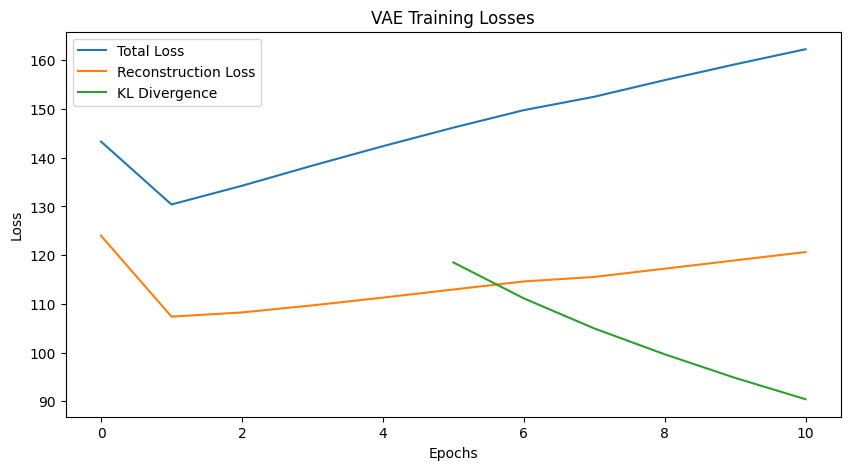

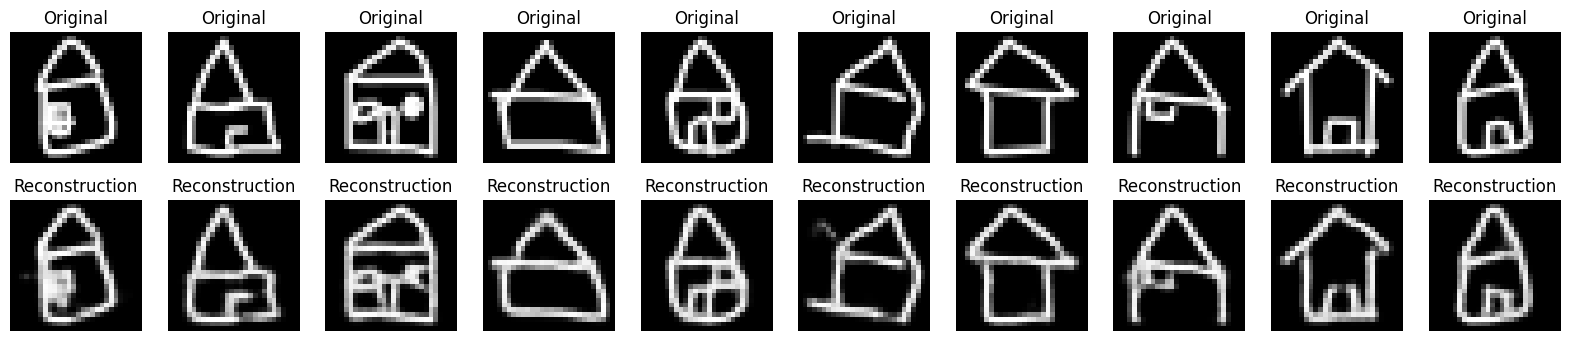

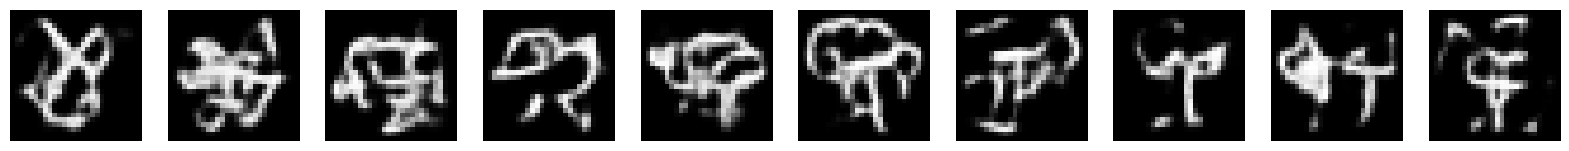

In [ ]:
config = Config(batch_size=128, learning_rate=0.001, epochs=15)
vae_run(config)

Using device: cuda
cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
Starting training...
====> Epoch: 1/15 Average train loss: 129.5585, Reconstruction loss: 110.7311, KL loss: 187.8279, Beta: 0.1000, Time: 123.58 seconds
====> Epoch: 1/15 Average test loss: 122.6390, Reconstruction loss: 103.1886, KL loss: 194.5038
====> Epoch: 2/15 Average train loss: 128.2609, Reconstruction loss: 105.7293, KL loss: 165.4671, Beta: 0.1360, Time: 129.97 seconds
====> Epoch: 2/15 Average test loss: 127.2848, Reconstruction loss: 104.9233, KL loss: 164.4226
====> Epoch: 3/15 Average train loss: 132.6252, Reconstruction loss: 106.8858, KL loss: 149.4899, Beta: 0.1720, Time: 128.39 seconds
====> Epoch: 3/15 Average test loss: 132.1525, Reconstruction loss: 106.3000, KL loss: 150.3053
====> Epoch: 4/15 Average train loss: 137.0286, Reconstruction loss: 108.5010, KL loss: 137.0189, Beta: 0.2080, Time: 126.20 seco

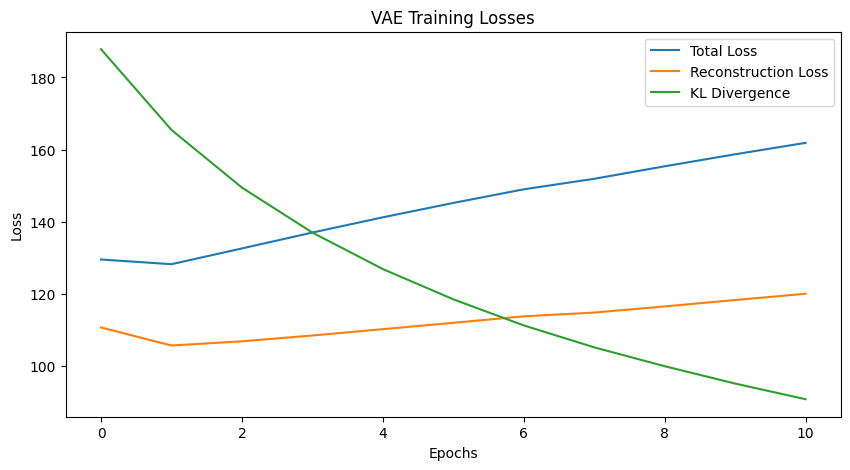

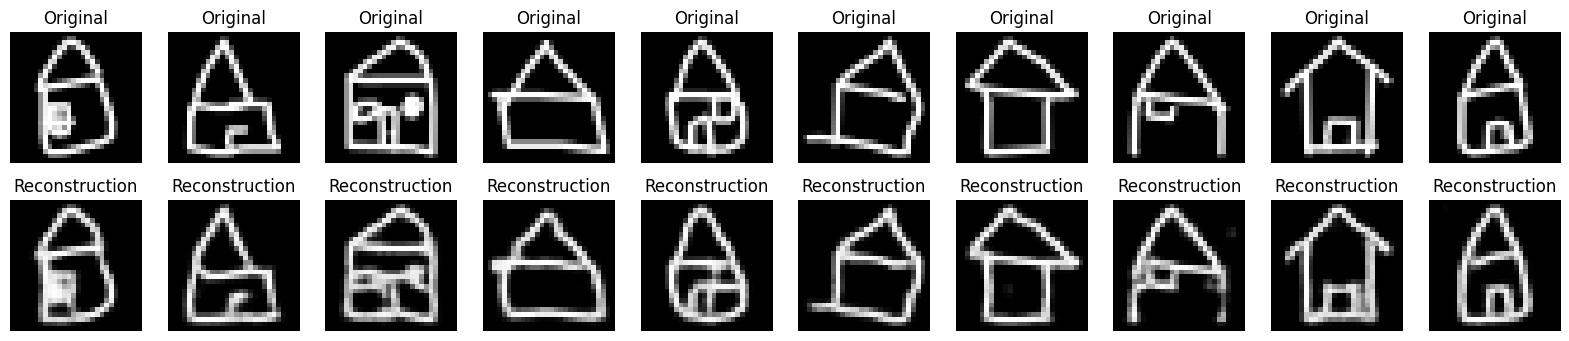

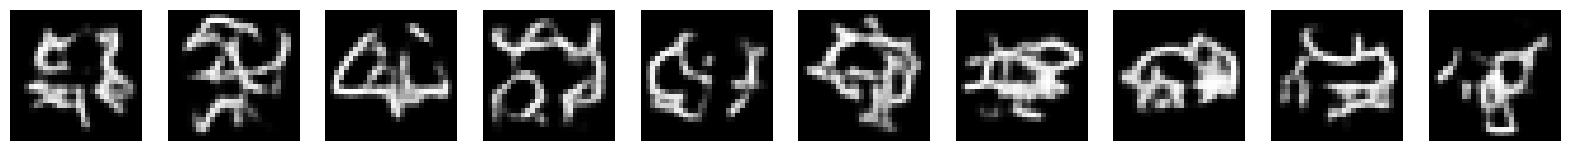

In [ ]:
config = Config(batch_size=32, learning_rate=0.001, epochs=15)
vae_run(config)

Using device: cuda
cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
Starting training...
====> Epoch: 1/700 Average train loss: 237.6868, Reconstruction loss: 237.6634, KL loss: inf, Beta: 0.0000, Time: 19.70 seconds
====> Epoch: 1/700 Average test loss: 176.8476, Reconstruction loss: 176.8476, KL loss: 479.2821
====> Epoch: 2/700 Average train loss: 153.0308, Reconstruction loss: 152.2159, KL loss: inf, Beta: 0.0014, Time: 19.66 seconds
====> Epoch: 2/700 Average test loss: 156.7293, Reconstruction loss: 156.0256, KL loss: 492.5812
====> Epoch: 3/700 Average train loss: 144.3995, Reconstruction loss: 143.0231, KL loss: inf, Beta: 0.0029, Time: 19.77 seconds
====> Epoch: 3/700 Average test loss: 149.6062, Reconstruction loss: 148.3686, KL loss: 433.1445
====> Epoch: 4/700 Average train loss: 140.6496, Reconstruction loss: 138.8918, KL loss: inf, Beta: 0.0043, Time: 19.37 seconds
====> Epoch: 

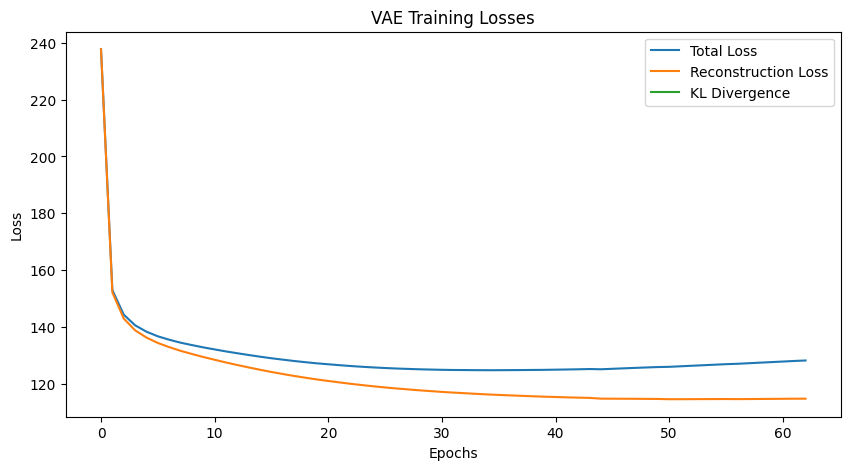

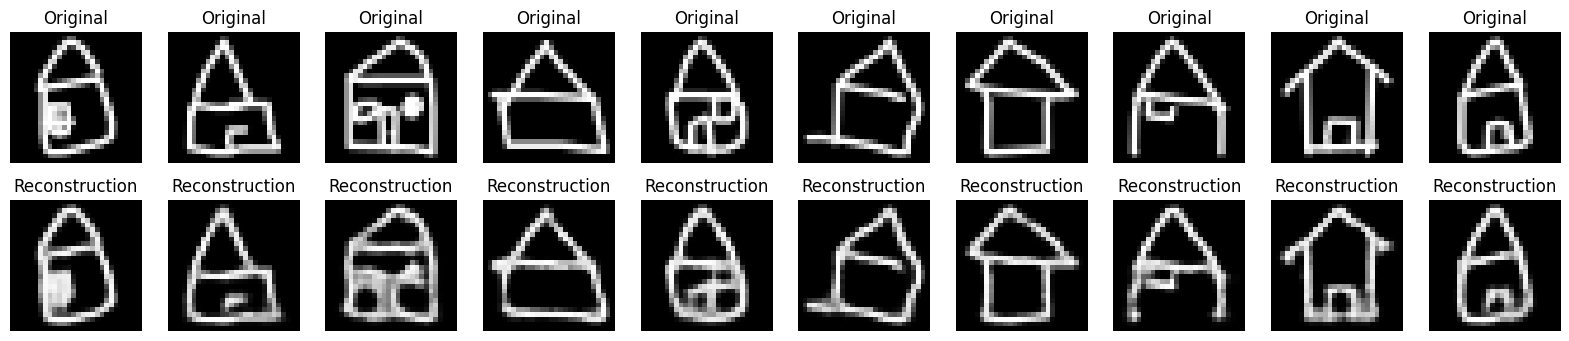

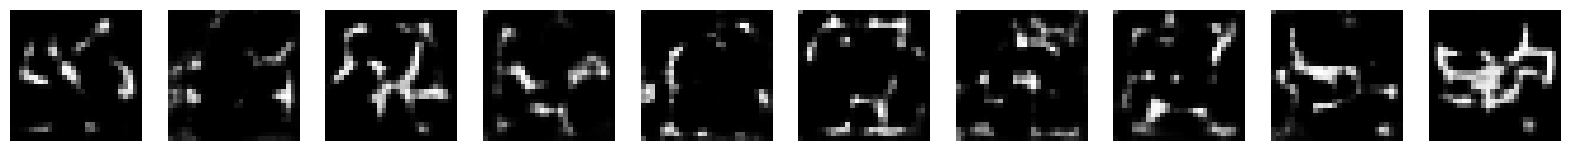

In [ ]:
config = Config(
    batch_size=1024,
    learning_rate=0.0001,
    epochs=700,
    latent_dim=64,
    beta_start=0.0,
    beta_increase_epochs=350,
    beta_end=0.5,
    early_stopping_patience=25,
    weight_decay=1e-5
)
vae_run(config)

Using device: cuda
cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
Starting training...
====> Epoch: 1/700 Average train loss: 124.0109, Reconstruction loss: 123.9087, KL loss: inf, Beta: 0.0000, Time: 64.16 seconds
====> Epoch: 1/700 Average test loss: 104.3651, Reconstruction loss: 104.3651, KL loss: 1233.0051
====> Epoch: 2/700 Average train loss: 102.4208, Reconstruction loss: 101.4835, KL loss: inf, Beta: 0.0014, Time: 64.16 seconds
====> Epoch: 2/700 Average test loss: 101.1053, Reconstruction loss: 100.2710, KL loss: 583.9939
====> Epoch: 3/700 Average train loss: 100.0889, Reconstruction loss: 98.6512, KL loss: inf, Beta: 0.0029, Time: 63.88 seconds
====> Epoch: 3/700 Average test loss: 99.4356, Reconstruction loss: 98.0321, KL loss: 491.2161
====> Epoch: 4/700 Average train loss: 98.8518, Reconstruction loss: 96.9308, KL loss: 441.8589, Beta: 0.0043, Time: 63.91 seconds
====> Epoch:

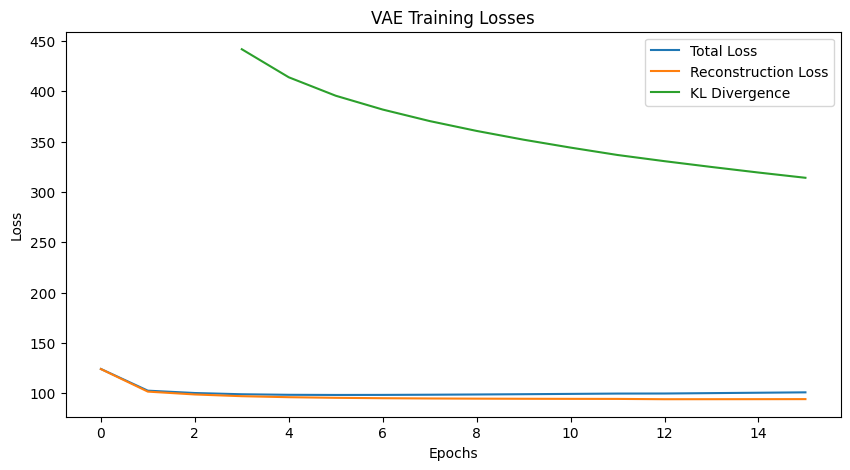

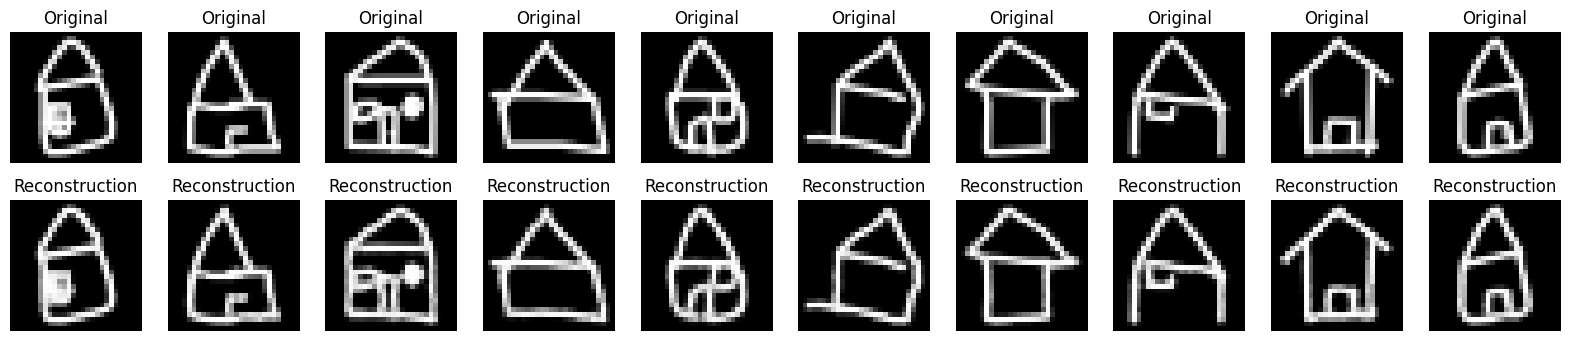

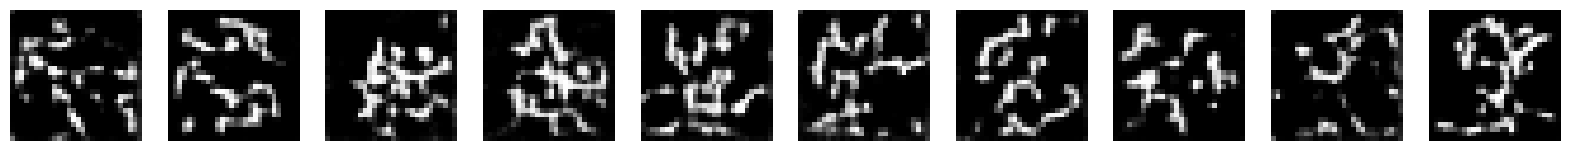

In [ ]:
config = Config(
    batch_size=64,
    learning_rate=0.0001,
    epochs=700,
    latent_dim=128,
    beta_start=0.0,
    beta_increase_epochs=350,
    beta_end=0.5,
    early_stopping_patience=10,
    weight_decay=1e-5
)
vae_run(config)

Using device: cuda


92.1MB [00:01, 88.0MB/s]


114MB [00:00, 175MB/s] 


99.9MB [00:00, 105MB/s]


108MB [00:01, 88.2MB/s]


101MB [00:00, 111MB/s] 


Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


====> Epoch: 1/15 Average train loss: 129.4826, Reconstruction loss: 110.6339, KL loss: 188.0009, Beta: 0.1000, Time: 140.33 seconds
====> Epoch: 1/15 Average test loss: 122.7988, Reconstruction loss: 103.8782, KL loss: 189.2066
====> Epoch: 2/15 Average train loss: 128.2638, Reconstruction loss: 105.6877, KL loss: 165.7861, Beta: 0.1360, Time: 136.58 seconds
====> Epoch: 2/15 Average test loss: 127.3063, Reconstruction loss: 104.4478, KL loss: 168.0772
====> Epoch: 3/15 Average train loss: 132.6369, Reconstruction loss: 106.8634, KL loss: 149.6783, Beta: 0.1720, Time: 136.99 seconds
====> Epoch: 3/15 Average test loss: 132.3583, Reconstruction loss: 106.1010, KL loss: 152.6588
====> Epoch: 4/15 Average train loss: 137.0764, Reconstruction loss: 108.5044, KL loss: 137.2245, Beta: 0.2080, Time: 136.61 seconds
====> Epoch: 4/15 Average test loss: 137.1586, Reconstruction loss: 107.4387, KL loss: 142.8843
====> Epoch: 5/15 Average train loss: 141.3007, Reconstruction loss: 110.2636, KL lo

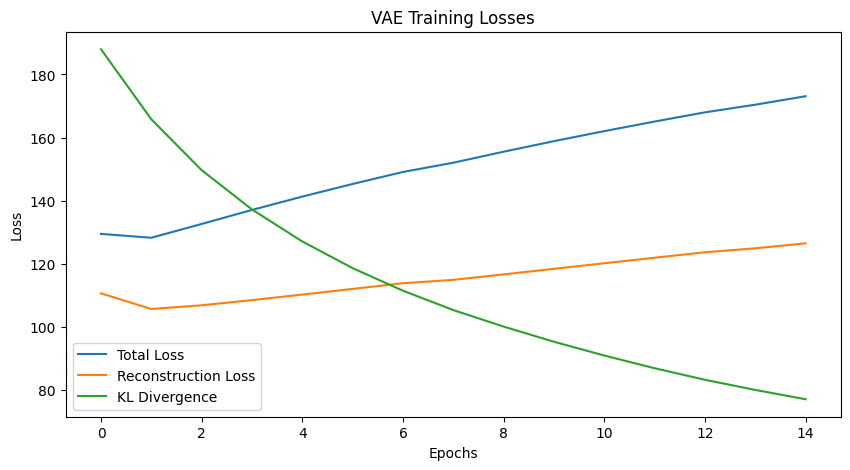

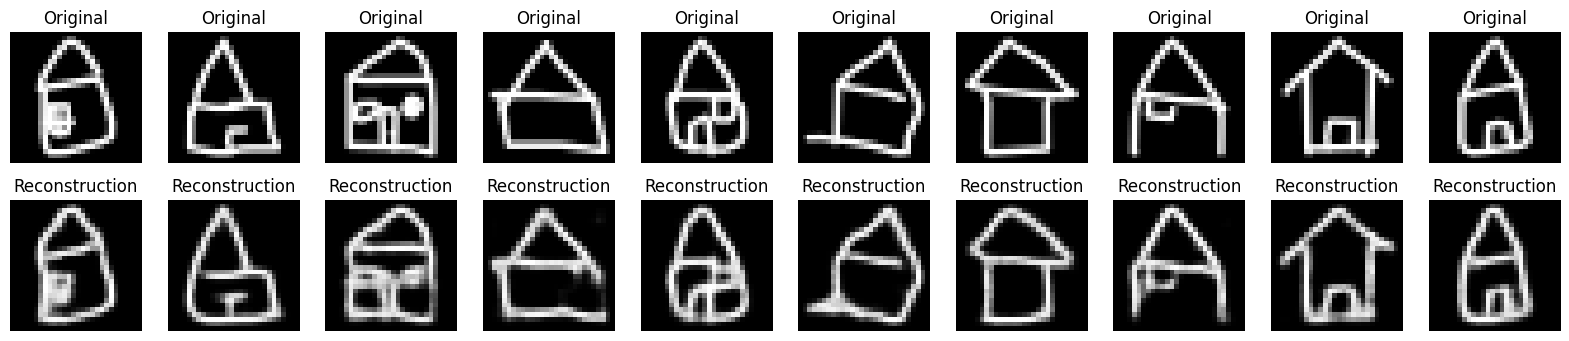

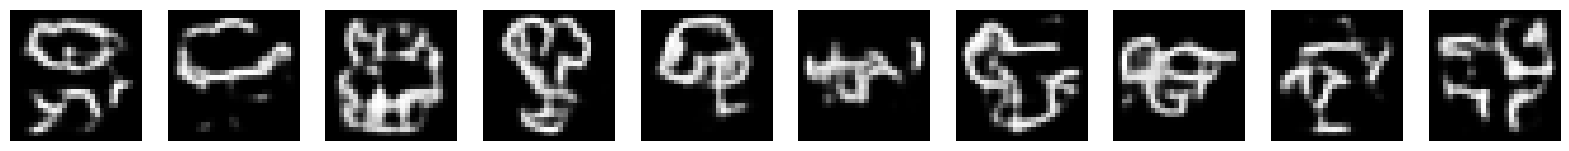

In [ ]:
config = Config(batch_size=28, learning_rate=0.001, epochs=15, early_stopping_patience=15)
vae_run(config)

Using device: cuda
cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
Starting training...
====> Epoch: 1/15 Average train loss: 177.3272, Reconstruction loss: 165.1685, KL loss: 120.8516, Beta: 0.1000, Time: 57.87 seconds
====> Epoch: 1/15 Average test loss: 161.0382, Reconstruction loss: 148.5289, KL loss: 125.0931
====> Epoch: 2/15 Average train loss: 152.5262, Reconstruction loss: 137.5320, KL loss: 109.9052, Beta: 0.1360, Time: 58.56 seconds
====> Epoch: 2/15 Average test loss: 150.7470, Reconstruction loss: 134.3347, KL loss: 120.6787
====> Epoch: 3/15 Average train loss: 151.1286, Reconstruction loss: 133.2456, KL loss: 103.7378, Beta: 0.1720, Time: 58.44 seconds
====> Epoch: 3/15 Average test loss: 149.5505, Reconstruction loss: 130.2769, KL loss: 112.0558
====> Epoch: 4/15 Average train loss: 152.2691, Reconstruction loss: 131.8509, KL loss: 97.9812, Beta: 0.2080, Time: 57.62 seconds
=

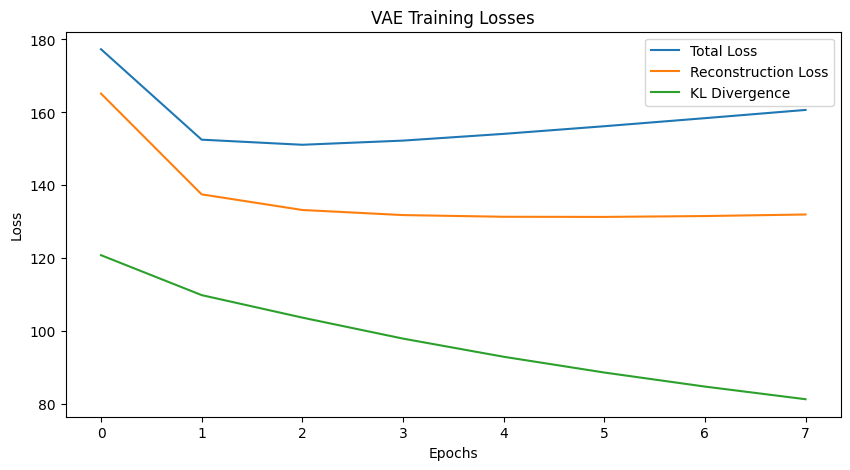

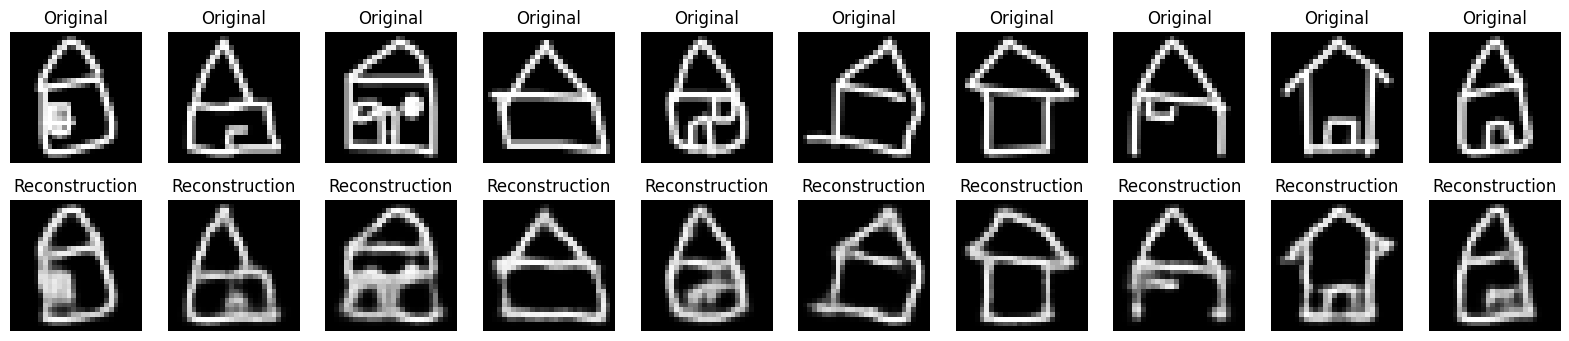

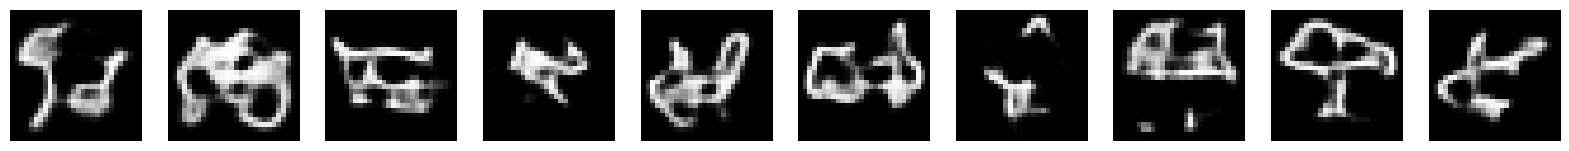

In [ ]:
config = Config(batch_size=64, learning_rate=0.0001, epochs=15, early_stopping_patience=5, latent_dim=50)
vae_run(config)

Using device: cuda
cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
Starting training...
====> Epoch: 1/1000 Average train loss: 136.7471, Reconstruction loss: 113.4848, KL loss: 231.8899, Beta: 0.1000, Time: 130.61 seconds
====> Epoch: 1/1000 Average test loss: 124.7835, Reconstruction loss: 101.9333, KL loss: 228.5020
====> Epoch: 2/1000 Average train loss: 129.5573, Reconstruction loss: 103.7632, KL loss: 189.3735, Beta: 0.1360, Time: 129.80 seconds
====> Epoch: 2/1000 Average test loss: 129.5363, Reconstruction loss: 103.4604, KL loss: 191.7346
====> Epoch: 3/1000 Average train loss: 134.0155, Reconstruction loss: 105.2547, KL loss: 167.0068, Beta: 0.1720, Time: 129.51 seconds
====> Epoch: 3/1000 Average test loss: 134.7536, Reconstruction loss: 105.4467, KL loss: 170.3884
====> Epoch: 4/1000 Average train loss: 138.6720, Reconstruction loss: 107.2520, KL loss: 150.8905, Beta: 0.2080, Tim

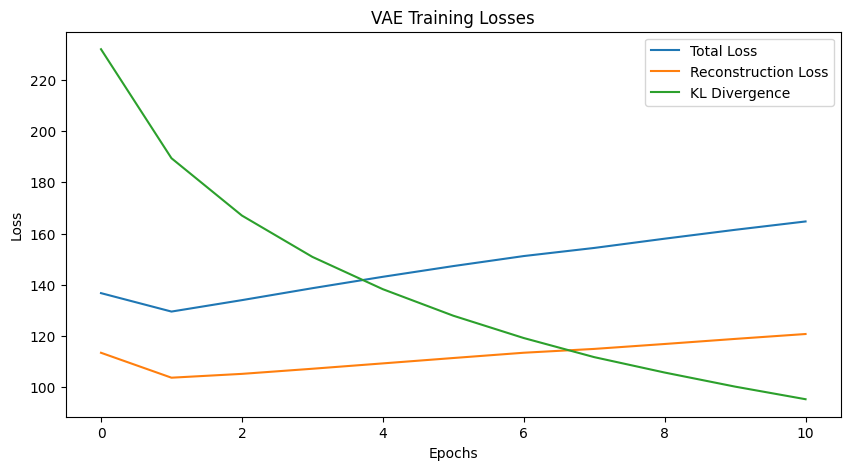

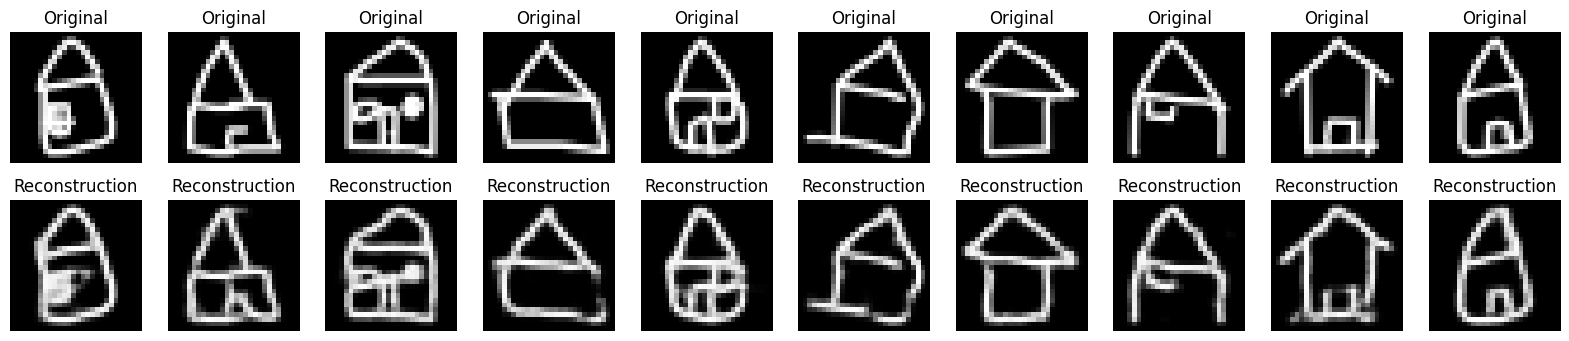

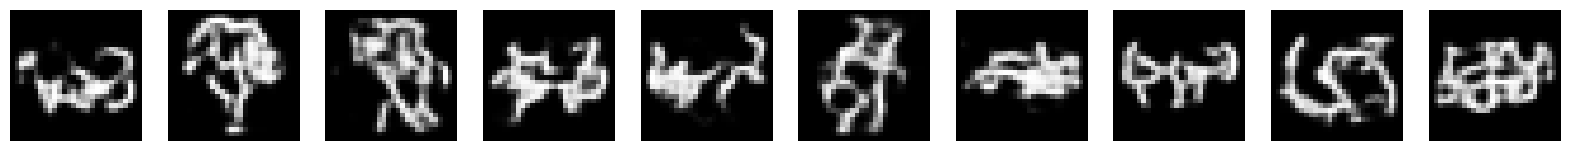

In [ ]:
config = Config(batch_size=32, learning_rate=0.0001, epochs=1000, early_stopping_patience=10, latent_dim=256)
vae_run(config)

Following a series of experiments with different configurations, the final model was selected as the best performing. This model employed the following parameters:

*   **Batch Size:** 32
*   **Learning Rate:** 0.0001
*   **Epochs:** 1000 (with early stopping)
*   **Early Stopping Patience:** 10 epochs
*   **Latent Dimension:** 256

Using device: cuda


<ipython-input-17-2c2cc7f15564>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


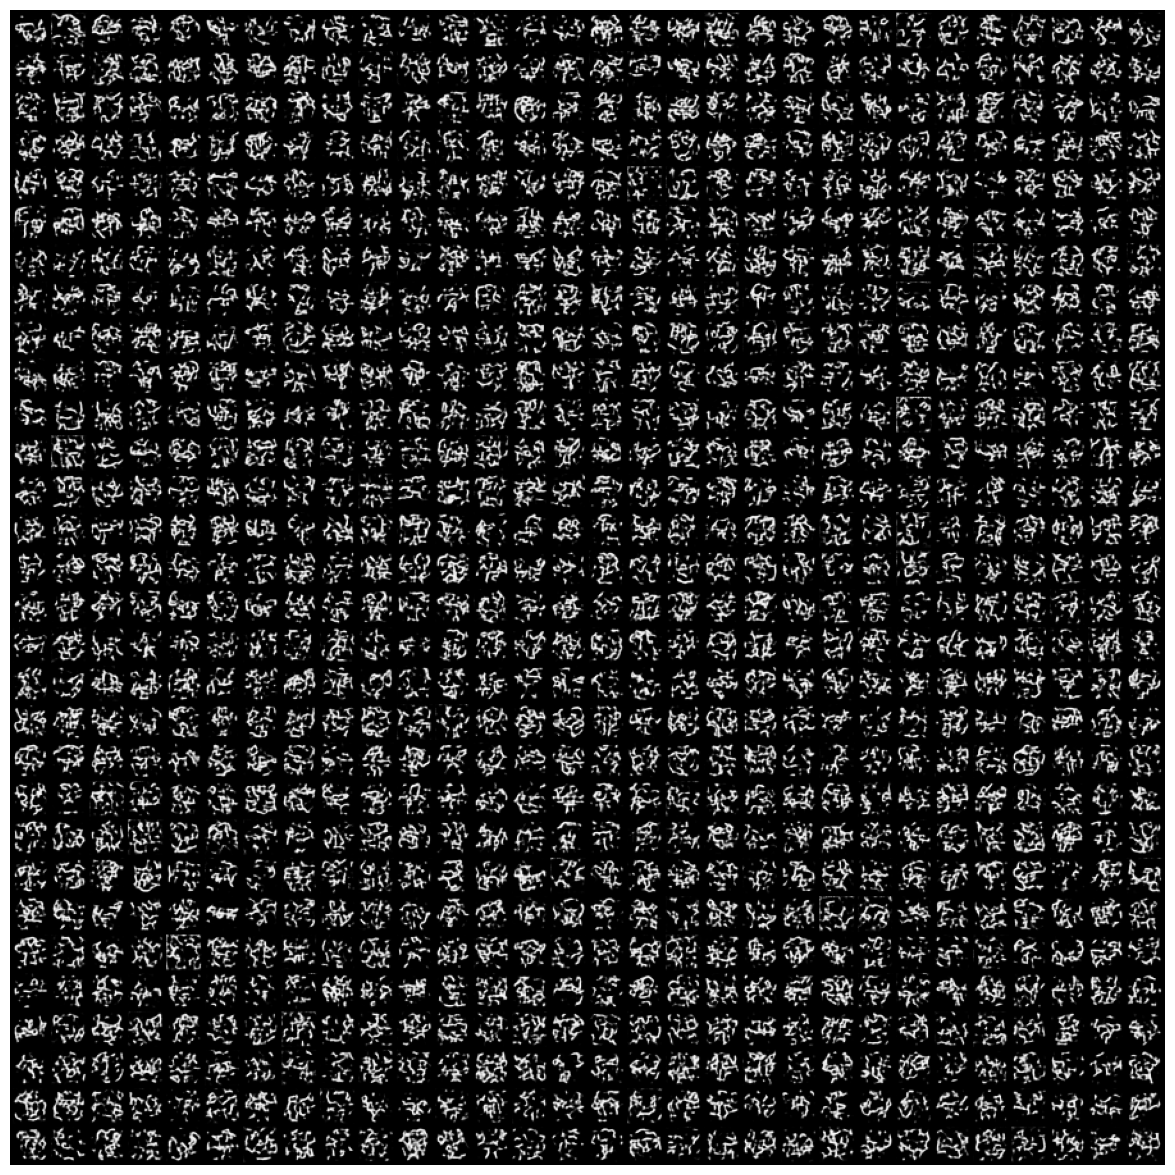

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def view_vae_images(model_path, config, n_rows=30, n_cols=30):
    # Load saved model
    model = VAE(config).to(config.device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Create latent vectors
    n_images = n_rows * n_cols
    with torch.no_grad():
        # Generate random latent vectors
        z = torch.randn(n_images, config.latent_dim).to(config.device)

        # Generate images from decoder
        generated = model.decoder(z)
        generated = torch.sigmoid(generated)

        # Move to CPU and reshape
        generated = generated.cpu()

        # Create image grid
        grid = make_grid(generated, nrow=n_rows, padding=2, normalize=True)

        # Display
        plt.figure(figsize=(15, 15))
        plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
        plt.axis('off')
        plt.show()

# Usage
config = Config(latent_dim=256)
view_vae_images('best_vae_model.h5', config)

# GAN Training

For this training, a Macbook Air M1 equipped with Apple Silicon was used. GPU acceleration was enabled through the mps device. The Python environment was based on version 3.9.21.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import urllib.request
from tqdm import tqdm

# Constants
IMAGE_SIZE = 28
CHANNELS = 1
BATCH_SIZE = 256
LATENT_DIM = 128
LATENT_DIM_GAN = 64
EPOCHS = 1000
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']
DATA_DIR = "quickdraw_data"
MAX_ITEMS_PER_CLASS = 100000
IMAGE_SAVE_DIR = "gan/image/v1_4"

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

In [14]:
def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    os.makedirs(DATA_DIR, exist_ok=True)
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, 
                    reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            return None, None
    return np.concatenate(all_data), np.concatenate(all_labels)

**Generate and Save Images Function**
- Generating sample images from random noise at regular intervals during training
- Providing a chronological record of how image generation improves across epochs

In [15]:
def generate_and_save_images(generator, epoch, batch_idx, noise, save_dir):
    """Generates and saves images from the generator with larger size and higher quality."""
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()
        
        # Rescale images from [-1, 1] to [0, 1]
        fake_images = 0.5 * fake_images + 0.5

        # Save image grid with large size
        fig = plt.figure(figsize=(10, 10))
        for i in range(fake_images.size(0)):
            plt.subplot(4, 4, i + 1)  # 4x4 grid for 16 images
            plt.imshow(fake_images[i, 0, :, :], cmap='gray')
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(
            f"{save_dir}/epoch_{epoch}_batch_{batch_idx}.png",
            dpi=300,  # Increase resolution
            bbox_inches='tight',
            pad_inches=0.1
        )
        plt.close(fig)

In [16]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_g_loss = float('inf')
        self.best_d_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, g_loss, d_loss):
        improved = False
        if g_loss < self.best_g_loss - self.min_delta:
            self.best_g_loss = g_loss
            improved = True
        if d_loss < self.best_d_loss - self.min_delta:
            self.best_d_loss = d_loss
            improved = True
        if not improved:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0

**Device Setup for M1 Macbook Air 2020 (Apple Silicon)**:

Using Metal Performance Shaders (MPS) backend for GPU acceleration on M1 Mac:

In [17]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [18]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 7 * 7 * 256),
            nn.LeakyReLU(0.2)
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 256, 7, 7)
        img = self.conv_layers(x)
        return img

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

Epoch [0/1000] Batch [0/1563] D_loss: 1.3902 G_loss: 0.6990
Epoch [0/1000] Batch [100/1563] D_loss: 1.3172 G_loss: 0.7025
Epoch [0/1000] Batch [200/1563] D_loss: 1.3413 G_loss: 0.7268
Epoch [0/1000] Batch [300/1563] D_loss: 1.1884 G_loss: 0.8380
Epoch [0/1000] Batch [400/1563] D_loss: 1.0257 G_loss: 0.9524
Epoch [0/1000] Batch [500/1563] D_loss: 0.9709 G_loss: 1.2996
Epoch [0/1000] Batch [600/1563] D_loss: 0.8381 G_loss: 1.2482
Epoch [0/1000] Batch [700/1563] D_loss: 0.7265 G_loss: 1.4778
Epoch [0/1000] Batch [800/1563] D_loss: 0.7899 G_loss: 1.2187
Epoch [0/1000] Batch [900/1563] D_loss: 0.6922 G_loss: 1.8963
Epoch [0/1000] Batch [1000/1563] D_loss: 0.7095 G_loss: 1.3225
Epoch [0/1000] Batch [1100/1563] D_loss: 0.7776 G_loss: 1.8999
Epoch [0/1000] Batch [1200/1563] D_loss: 0.7489 G_loss: 2.1431
Epoch [0/1000] Batch [1300/1563] D_loss: 0.5498 G_loss: 1.7522
Epoch [0/1000] Batch [1400/1563] D_loss: 0.5736 G_loss: 1.6354
Epoch [0/1000] Batch [1500/1563] D_loss: 0.7408 G_loss: 1.8193
Epoc

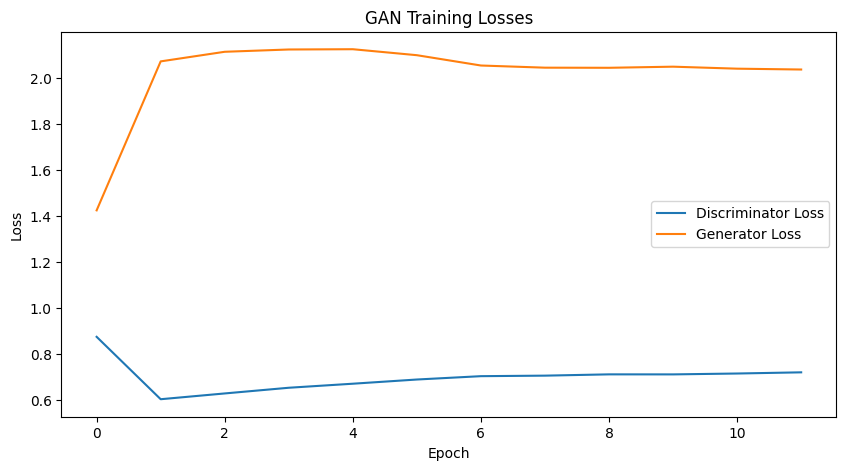

In [31]:
# Download and load data
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)

if x_data is not None and labels is not None:
    # Prepare data
    x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.
    
    # Split train/test
    train_size = int(0.8 * len(x_data))
    x_train = torch.from_numpy(x_data[:train_size]).float()
    y_train = torch.from_numpy(labels[:train_size]).long()
    
    # Create DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    # Initialize models
    generator = Generator(LATENT_DIM_GAN).to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    # Early stopping
    early_stopping = EarlyStopping(patience=10)

    # Training
    start_time = time.time()
    d_losses = []
    g_losses = []

    for epoch in range(EPOCHS):
        epoch_d_losses = []
        epoch_g_losses = []
        
        for batch_idx, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)
            
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, LATENT_DIM_GAN).to(device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            optimizer_G.step()

            epoch_d_losses.append(d_loss.item())
            epoch_g_losses.append(g_loss.item())

            if batch_idx % 100 == 0:
                generate_and_save_images(
                    generator,
                    epoch,
                    batch_idx,
                    noise[:16],
                    save_dir=IMAGE_SAVE_DIR
                )
                print(f'Epoch [{epoch}/{EPOCHS}] Batch [{batch_idx}/{len(train_loader)}] '
                        f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')

        # Calculate average losses
        avg_d_loss = sum(epoch_d_losses) / len(epoch_d_losses)
        avg_g_loss = sum(epoch_g_losses) / len(epoch_g_losses)
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)

        # Early stopping check
        early_stopping(avg_g_loss, avg_d_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # Save model
    torch.save(generator.state_dict(), "improved_gan_generator.h5")
    print("Improved GAN generator saved as improved_gan_generator.h5")

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.show()

In [21]:
# Create a generator instance
generator = Generator(latent_dim=64)

# Load the saved weights
generator.load_state_dict(torch.load("gan/improved_gan_generator_11epoches_500000datasets.h5"))

# Put the generator in evaluation mode (important for layers like BatchNorm)
generator.eval()

/var/folders/r4/752pqpt90zxczqv7ghd87g7m0000gp/T/ipykernel_73562/2797551852.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("gan/imp

Generator(
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=12544, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_layers): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

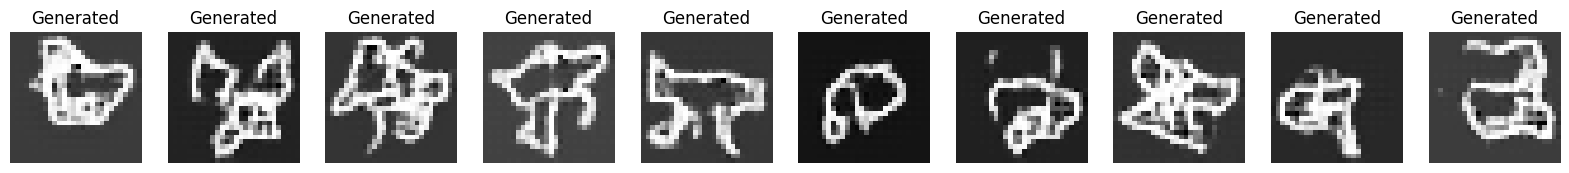

In [22]:
LATENT_DIM_GAN = 64
def generate_images(generator, n=10, latent_dim=LATENT_DIM_GAN):
    """Generates new images by sampling from the latent space."""

    with torch.no_grad():  # Disable gradient calculations
        # Sample random noise vectors
        noise = torch.randn(n, latent_dim)

        # Generate images
        generated_images = generator(noise)

    # Rescale images from [-1, 1] to [0, 1] (if you used tanh activation)
    generated_images = 0.5 * generated_images + 0.5

    # Plot the images
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 2))
    for i, image in enumerate(generated_images):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(image.squeeze().detach().numpy(), cmap='gray')  # Convert to NumPy and remove channel dimension
        plt.title("Generated")
        plt.axis("off")
    plt.show()

# Generate 10 images
generate_images(generator, n=10)

/var/folders/r4/752pqpt90zxczqv7ghd87g7m0000gp/T/ipykernel_73562/959360130.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator1.load_state_dict(torch.load("gan/im

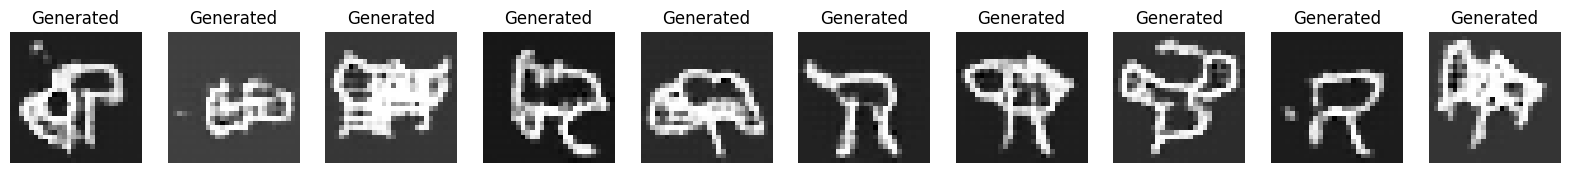

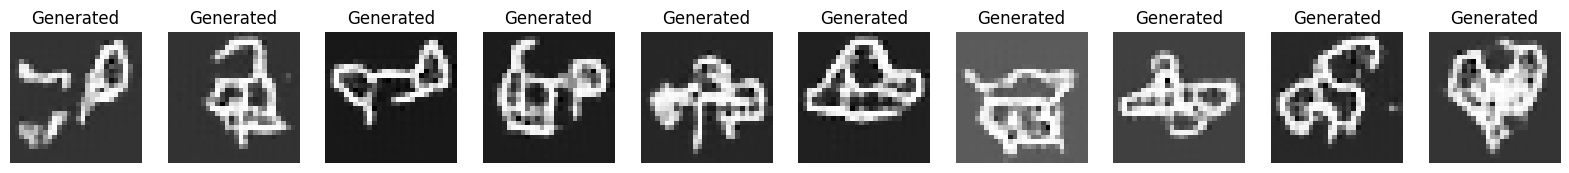

In [23]:
# Define 2 different latent dimensions
LATENT_DIM_GAN1 = 64
LATENT_DIM_GAN2 = 128

# Create 2 generators with different latent_dim
generator1 = Generator(latent_dim=LATENT_DIM_GAN1)
generator2 = Generator(latent_dim=LATENT_DIM_GAN2)

# Load weights
generator1.load_state_dict(torch.load("gan/improved_gan_generator_11epoches_500000datasets.h5"))
generator2.load_state_dict(torch.load("gan/improved_gan_generator_1000epoches_15000datasets.h5"))

# Switch to evaluation mode
generator1.eval()
generator2.eval()

# Create separate noise vectors for each generator
noise1 = torch.randn(10, LATENT_DIM_GAN1, device=device)
noise2 = torch.randn(10, LATENT_DIM_GAN2, device=device)

# Generate images
generate_images(generator1, n=10, latent_dim=LATENT_DIM_GAN1)
generate_images(generator2, n=10, latent_dim=LATENT_DIM_GAN2)


In [ ]:
import torch
import torch_fidelity
import os
from torchvision.utils import save_image

# Create directories to save images
os.makedirs("gan/gan/generated_images_model_1", exist_ok=True)
os.makedirs("gan/generated_images_model_2", exist_ok=True)

# Generate images from generator 1
noise1 = torch.randn(1000, LATENT_DIM_GAN1)  # Generate more images for better evaluation
with torch.no_grad():
    fake_images1 = generator1(noise1)
    # Save each image to directory
    for i, img in enumerate(fake_images1):
        save_image(img, f"gan/generated_images_model_1/image_{i}.png")

# Generate images from generator 2  
noise2 = torch.randn(1000, LATENT_DIM_GAN2)
with torch.no_grad():
    fake_images2 = generator2(noise2)
    for i, img in enumerate(fake_images2):
        save_image(img, f"gan/generated_images_model_2/image_{i}.png")

# Calculate FID score
metrics = torch_fidelity.calculate_metrics(
    input1="gan/generated_images_model_1",
    input2="gan/generated_images_model_2", 
    cuda=False,  # Use CPU
    fid=True,
    verbose=False
)

print(f"FID score between two generators: {metrics['frechet_inception_distance']:.2f}")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /Users/minh/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:08<00:00, 11.9MB/s]


FID score between two generators: 11.31


In [20]:
import torch
import torch_fidelity
import os
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset

# Create directories for generated and real images
os.makedirs("gan/generated_images_model_1", exist_ok=True)
os.makedirs("gan/generated_images_model_2", exist_ok=True)
os.makedirs("gan/real_images", exist_ok=True)

# Save real images
def save_real_images(data_loader, num_images=1000):
    count = 0
    for images, _ in data_loader:
        if count >= num_images:
            break
        for img in images:
            save_image(img, f"gan/real_images/real_{count}.png")
            count += 1
            if count >= num_images:
                break

# Generate and save images from generator 1
noise1 = torch.randn(1000, LATENT_DIM_GAN1)
with torch.no_grad():
    fake_images1 = generator1(noise1)
    for i, img in enumerate(fake_images1):
        save_image(img, f"gan/generated_images_model_1/image_{i}.png")

# Generate and save images from generator 2
noise2 = torch.randn(1000, LATENT_DIM_GAN2)
with torch.no_grad():
    fake_images2 = generator2(noise2)
    for i, img in enumerate(fake_images2):
        save_image(img, f"gan/generated_images_model_2/image_{i}.png")

# Save real images
save_real_images(train_loader)

# Calculate FID scores
fid_score1 = torch_fidelity.calculate_metrics(
    input1="gan/generated_images_model_1",
    input2="gan/real_images",
    cuda=False,
    fid=True,
    verbose=False
)

fid_score2 = torch_fidelity.calculate_metrics(
    input1="gan/generated_images_model_2",
    input2="gan/real_images",
    cuda=False,
    fid=True,
    verbose=False
)

print(f"FID score for Generator 1 vs Real Images: {fid_score1['frechet_inception_distance']:.2f}")
print(f"FID score for Generator 2 vs Real Images: {fid_score2['frechet_inception_distance']:.2f}")


FID score for Generator 1 vs Real Images: 49.33
FID score for Generator 2 vs Real Images: 45.52


While both generators were evaluated, **Generator 2** demonstrated superior performance based on a combination of quantitative and qualitative assessments. Quantitatively, Generator 2 achieved a lower, and thus better, **Fréchet Inception Distance (FID) score of 45.52** compared to Generator 1's score of 49.33. Qualitatively, the images generated by Generator 2 were observed to be visually clearer, more diverse, and more closely resembled the target classes from the Quick, Draw! dataset. Therefore, based on both the FID score and visual inspection, Generator 2 is selected as the best GAN model for this project. [Link to model best-gan-model.h5](./best-gan-model.h5)

/var/folders/r4/752pqpt90zxczqv7ghd87g7m0000gp/T/ipykernel_73562/550396683.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_best.load_state_dict(torch.load("bes

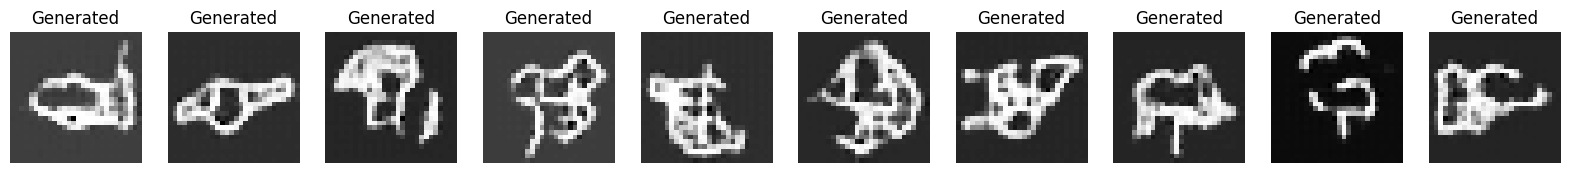

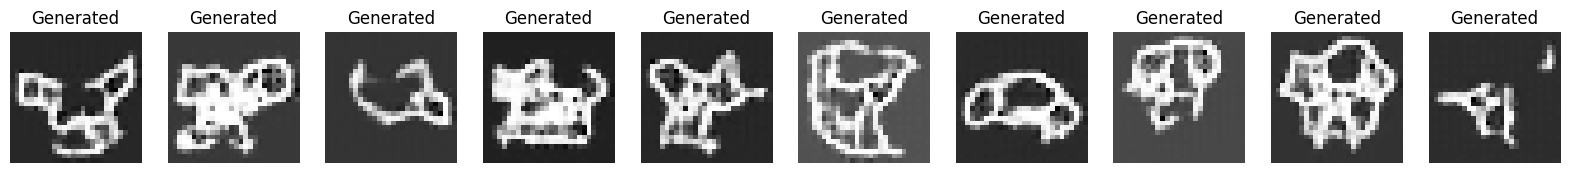

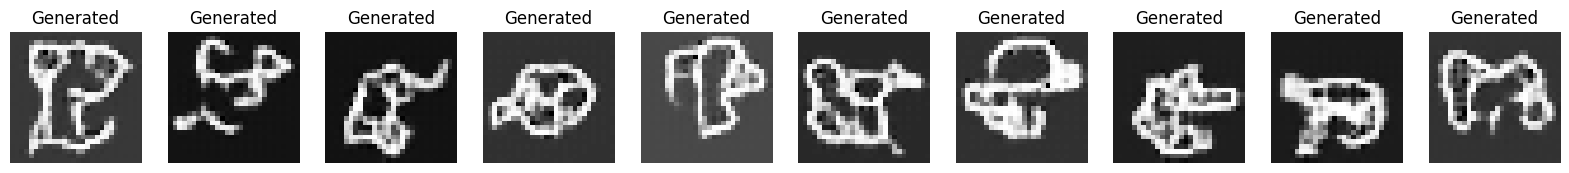

In [28]:
LATENT_DIM_GAN2 = 128
# Create a generator instance
generator_best = Generator(latent_dim=128)

# Load the saved weights
generator_best.load_state_dict(torch.load("best-gan-model.h5"))

# Put the generator in evaluation mode (important for layers like BatchNorm)
generator_best.eval()

generate_images(generator_best, n=10, latent_dim=128)
generate_images(generator_best, n=10, latent_dim=128)
generate_images(generator_best, n=10, latent_dim=128)


The code below is the training code of generator 2 in over 6 hours.

Using device: mps
cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
Epoch [0/1000] Batch [0/12] D_loss: 1.3895 G_loss: 0.7202
Epoch [1/1000] Batch [0/12] D_loss: 1.4108 G_loss: 0.7549
Epoch [2/1000] Batch [0/12] D_loss: 1.3903 G_loss: 0.7449
Epoch [3/1000] Batch [0/12] D_loss: 1.3790 G_loss: 0.8122
Epoch [4/1000] Batch [0/12] D_loss: 1.4021 G_loss: 0.6884
Epoch [5/1000] Batch [0/12] D_loss: 1.3936 G_loss: 0.6677
Epoch [6/1000] Batch [0/12] D_loss: 1.3737 G_loss: 0.7096
Epoch [7/1000] Batch [0/12] D_loss: 1.3519 G_loss: 0.8124
Epoch [8/1000] Batch [0/12] D_loss: 1.3303 G_loss: 0.7042
Epoch [9/1000] Batch [0/12] D_loss: 1.3249 G_loss: 0.8189
Epoch [10/1000] Batch [0/12] D_loss: 1.3290 G_loss: 0.7275
Epoch [11/1000] Batch [0/12] D_loss: 1.3172 G_loss: 0.9306
Epoch [12/1000] Batch [0/12] D_loss: 1.3666 G_loss: 0.7214
Epoch [13/1000] Batch [0/12] D_loss: 1.3377 G_loss: 0.7596
Epoch [14/1000] Batch 

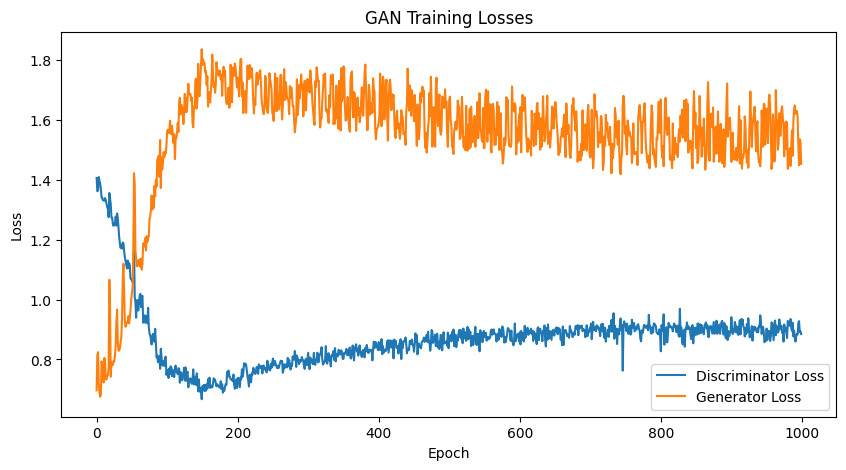

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import urllib.request
from tqdm import tqdm

# Constants
IMAGE_SIZE = 28
CHANNELS = 1 
BATCH_SIZE = 1024  # Increase batch size for M1
LATENT_DIM = 128
LATENT_DIM_GAN = 128
EPOCHS = 1000
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']
DATA_DIR = "quickdraw_data"
MAX_ITEMS_PER_CLASS = 3000

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Set MPS device for M1
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    os.makedirs(DATA_DIR, exist_ok=True)
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, 
                    reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            return None, None
    return np.concatenate(all_data), np.concatenate(all_labels)

class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 7 * 7 * 256),
            nn.LeakyReLU(0.2)
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 256, 7, 7)
        img = self.conv_layers(x)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Download and load data
download_quickdraw_data(CLASSES)
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)

if x_data is not None and labels is not None:
    x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.
    
    # Split train/test
    train_size = int(0.8 * len(x_data))
    x_train = torch.from_numpy(x_data[:train_size]).float()
    y_train = torch.from_numpy(labels[:train_size]).long()
    
    # Create DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    # Initialize models
    generator = Generator(LATENT_DIM_GAN).to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    # Training
    start_time = time.time()
    d_losses = []
    g_losses = []

    for epoch in range(EPOCHS):
        epoch_d_losses = []
        epoch_g_losses = []
        
        for batch_idx, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)
            
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, LATENT_DIM_GAN).to(device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            optimizer_G.step()

            epoch_d_losses.append(d_loss.item())
            epoch_g_losses.append(g_loss.item())

            # save image for visualization
            if batch_idx % 100 == 0:  
                generate_and_save_images(
                    generator,
                    epoch,
                    batch_idx,
                    noise[:16],  # Only save first 16 images
                    save_dir
                )
                print(f'Epoch [{epoch}/{EPOCHS}] Batch [{batch_idx}/{len(train_loader)}] '
                    f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')

        # Calculate average losses
        d_losses.append(sum(epoch_d_losses) / len(epoch_d_losses))
        g_losses.append(sum(epoch_g_losses) / len(epoch_g_losses))

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # Save model
    torch.save(generator.state_dict(), "improved_gan_generator.h5")
    print("Improved GAN generator saved as improved_gan_generator.h5")

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.show()


The images displayed below showcase the progression of the model's learning process throughout the training epochs. Each image corresponds to a specific epoch, allowing for a visual assessment of the generated output at different stages of training.

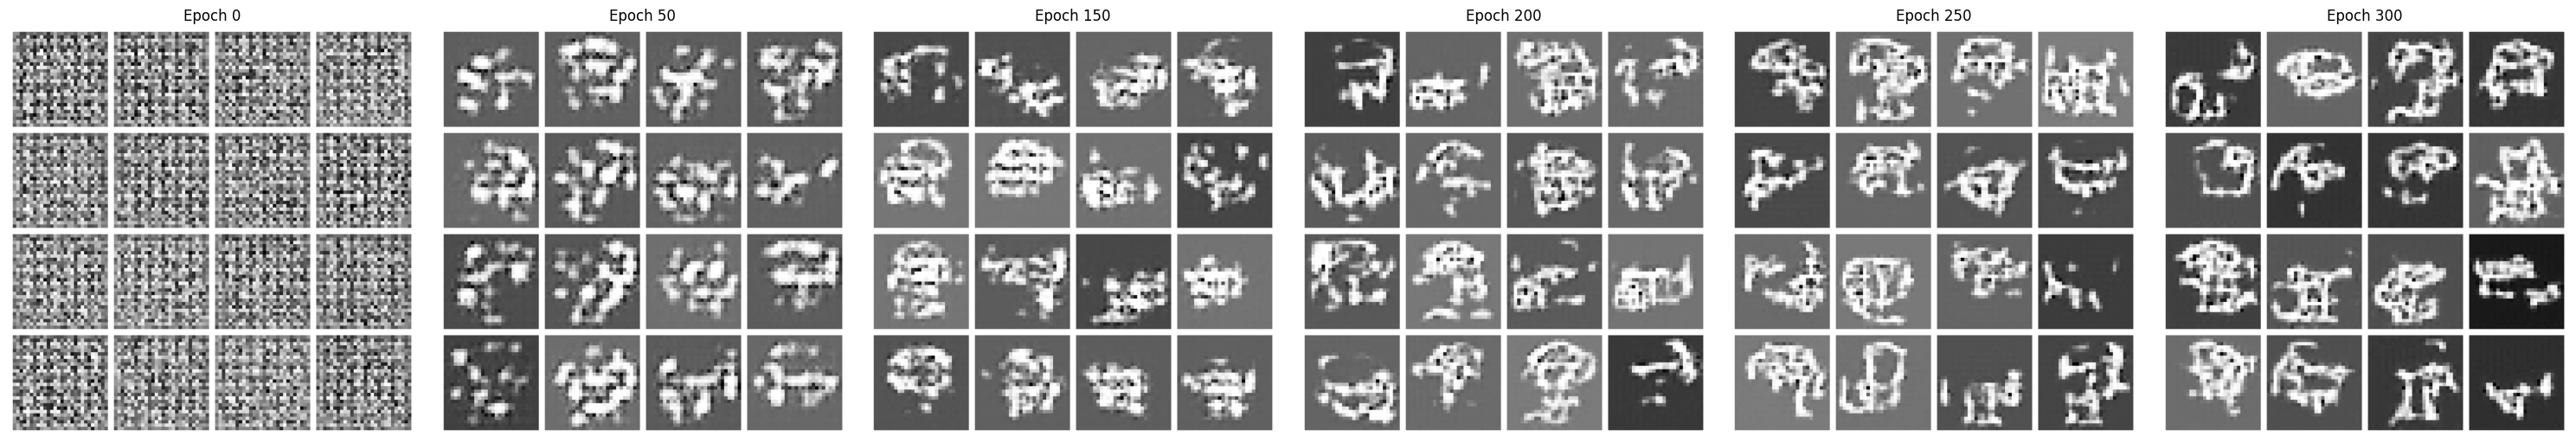

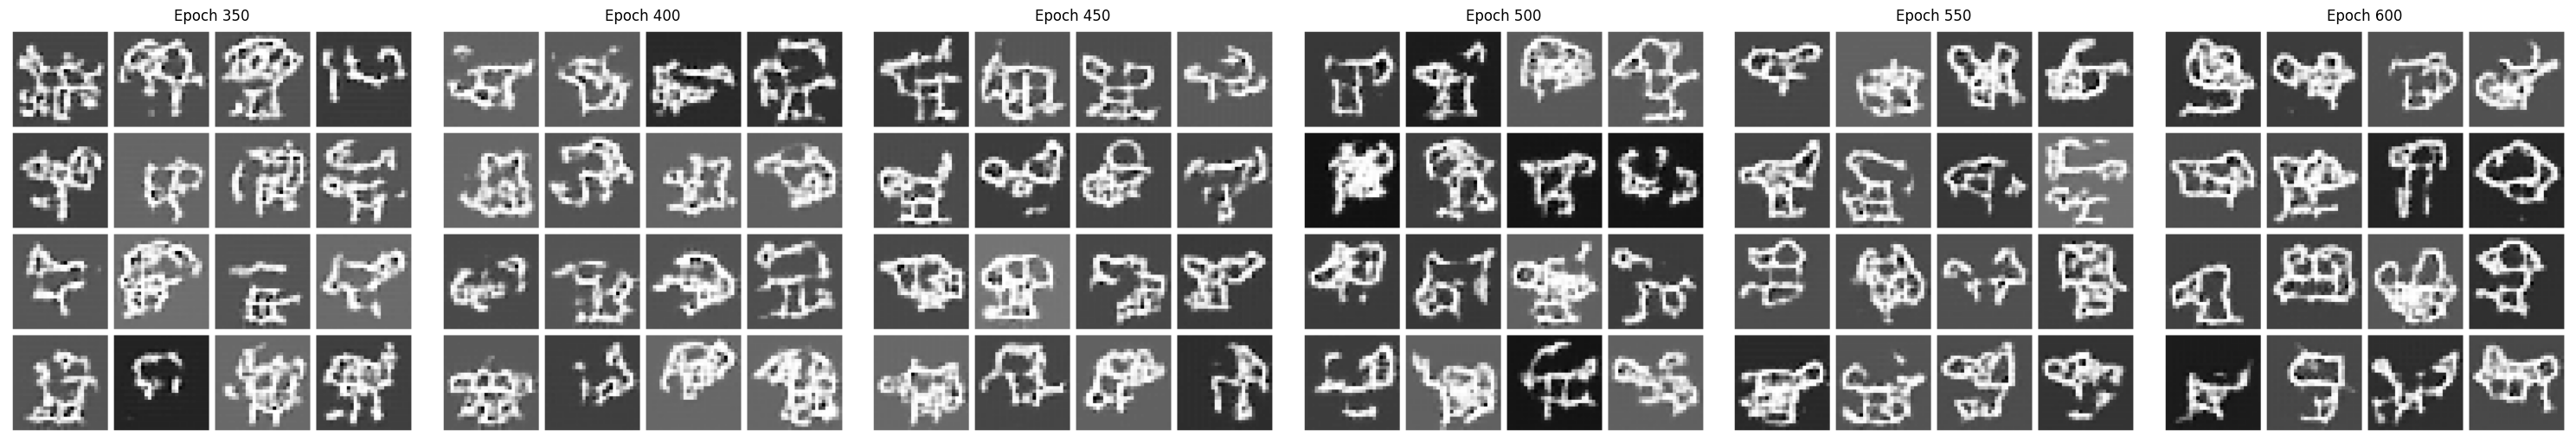

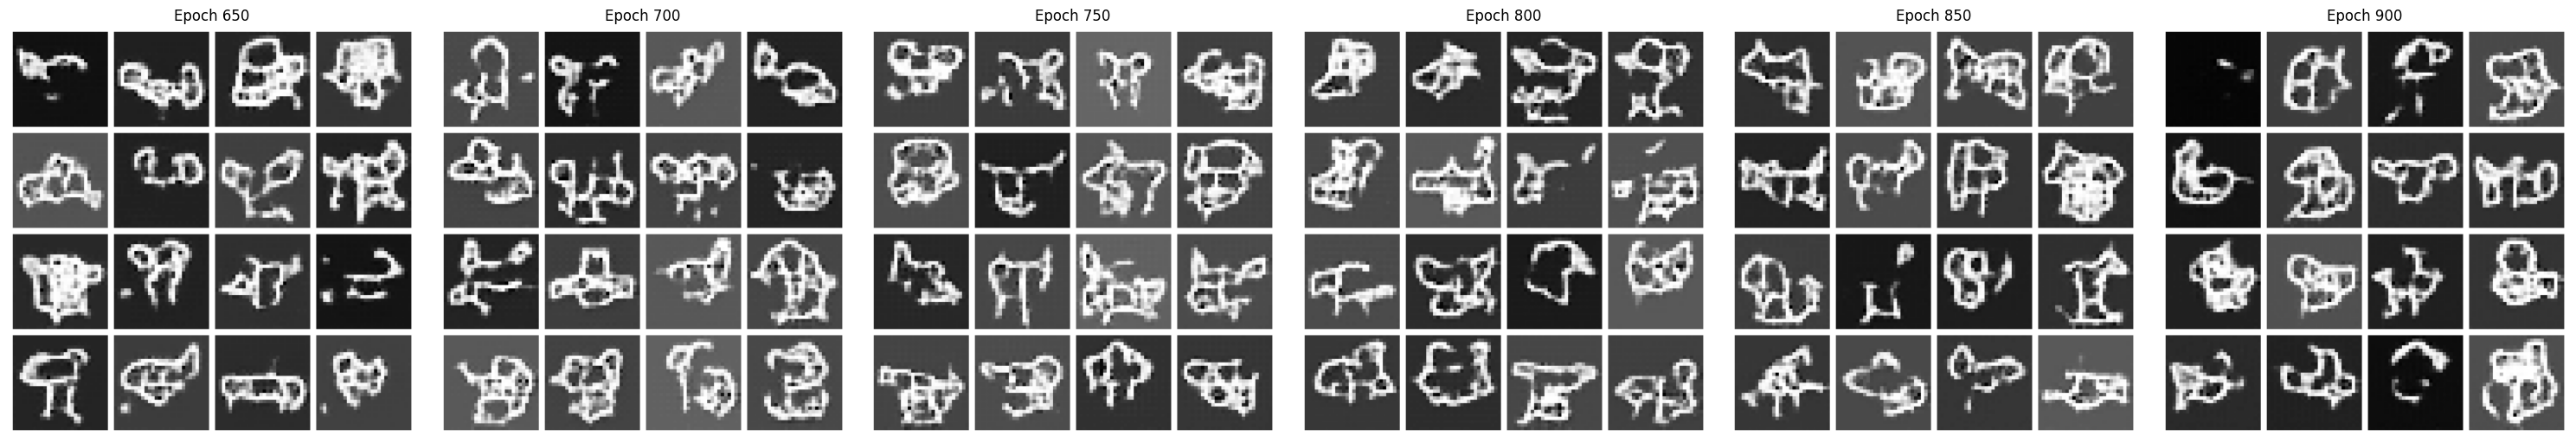

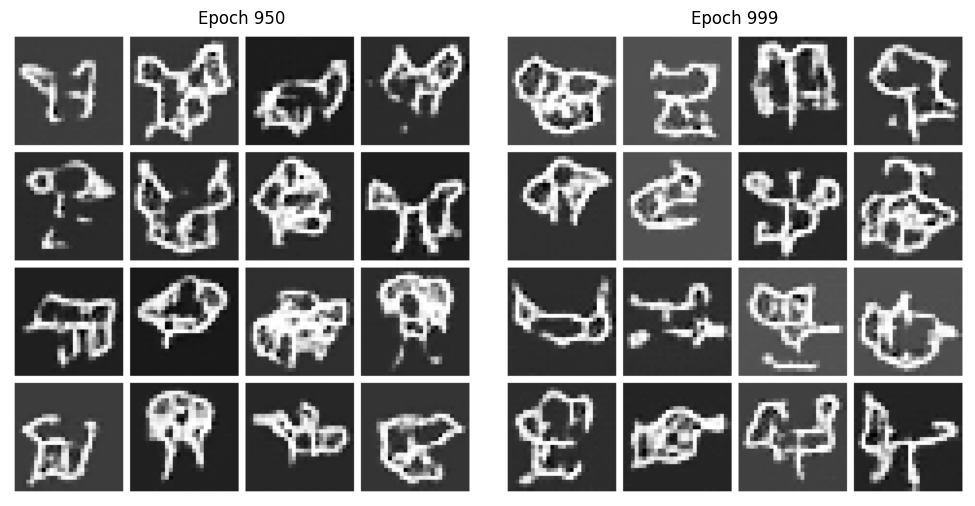

In [34]:
import matplotlib.pyplot as plt
import os

def display_gan_images_by_epoch(image_dir, epochs, base_filename="gan_generated_image_epoch_", extension=".png"):
    """
    Displays images generated by a GAN at specified epochs.

    Args:
        image_dir: The directory where the generated images are saved.
        epochs: A list of epochs to display images for (e.g., [0, 50, 150, 200]).
        base_filename: The base filename for the generated images (default: "gan_generated_image_epoch_").
        extension: The file extension of the images (default: ".png").
    """

    num_epochs = len(epochs)
    fig, axes = plt.subplots(1, num_epochs, figsize=(5*num_epochs, 5))
    for i, epoch in enumerate(epochs):
        filename = os.path.join(image_dir, f"epoch_{epoch}_batch_0{extension}")
        try:
            img = plt.imread(filename)
            ax = axes[i]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Epoch {epoch}")
            ax.axis('off')
        except FileNotFoundError:
            print(f"Error: Image not found for epoch {epoch} at {filename}")

    plt.tight_layout()
    plt.show()

# Example usage:
image_directory = "gan/image/v1_3/"
epochs_to_display = [0, 50, 150, 200, 250, 300]  
display_gan_images_by_epoch(image_directory, epochs_to_display)

epochs_to_display = [350, 400, 450, 500, 550, 600]
display_gan_images_by_epoch(image_directory, epochs_to_display)

epochs_to_display = [650, 700, 750, 800, 850, 900]
display_gan_images_by_epoch(image_directory, epochs_to_display)

epochs_to_display = [950, 999]
display_gan_images_by_epoch(image_directory, epochs_to_display)

# Conclusion

This project explored the application of Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs) for image generation using the Quick, Draw! dataset. Both models successfully learned to generate recognizable images from the five chosen classes (cat, dog, bird, tree, and house), but exhibited distinct strengths and weaknesses. The VAE, while faster to train, produced images that appeared more diffused and less defined, particularly in capturing finer details. This may be attributed to the VAE's inherent focus on learning a smooth and continuous latent space, which can sometimes lead to a loss of high-frequency information. On the other hand, the GAN, after undergoing a more extensive and sensitive training process, demonstrated a superior ability to generate images with sharper lines and finer details. This suggests that the GAN's adversarial training, while more challenging to optimize, ultimately allowed it to better capture the intricate stroke patterns characteristic of the Quick, Draw! dataset.

Throughout the project, several key techniques were employed to enhance model performance and training efficiency. These included data normalization to the range of [0, 1], the implementation of improved VAE and GAN architectures utilizing convolutional and transposed convolutional layers, batch normalization for improved training stability, and the Adam optimizer for efficient gradient-based optimization. Additionally, a learning rate scheduler (ReduceLROnPlateau) was implemented for the VAE to dynamically adjust the learning rate during training, while early stopping was used to prevent overfitting. Finally, GPU acceleration, leveraging either Apple's Metal Performance Shaders (MPS) or NVIDIA's CUDA, significantly reduced training time. These techniques collectively contributed to the successful implementation and training of both generative models.